# Тональность текста

В блокноте text_classification.ipynb разобрали анализ тональности используя полносвязанную сеть сделать на тех же данных

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm


import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [3]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [4]:
train_batch_size = 625
val_batch_size=157
test_batch_size=782
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=train_batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=val_batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_train_val_ds= tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=test_batch_size    
    )

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=test_batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [5]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [6]:
text_train_batch, label_train_batch = next(iter(raw_train_ds))
text_valid_batch, label_valid_batch = next(iter(raw_val_ds))
text_test_batch, label_test_batch = next(iter(raw_test_ds))
text_train_val_batch, label_train_val_batch = next(iter(raw_train_val_ds))


first_review, first_label = text_train_batch[0], label_train_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])

Review tf.Tensor(b'This is an incredible comeback from movie director mastermind, Tsui Hark. It is one of a few movies that deserves to come a face to face match to Steven Chow\'s Shaolin Soccer. From the moment the movie started,there was astronishing backdrops at every edge which were<br /><br />deplicted with superb style. If you are a science fiction or chinese martial arts "geek", you\'ll love the excessive amounts of many 3D effects and realistic computer generated weapons. There, comes a fine performance(as always) from Ekin Cheung who plays "Sky King". He teams up with Louis Koo(Red) who i was very impressed by his flexible "wing" which deflected incoming attacks. The fighting movements of these actors were proficient in every way. Not only is the action superb but the has a somewhat complex storyline. Many Criticisers of this movie complain of the lack of story/theme or just "shoved in random bits of debrise" and even describe as "The Legend of Poo". However, the viewer cannot

In [7]:
text_train_batch=custom_standardization(text_train_batch)
text_valid_batch=custom_standardization(text_valid_batch)
text_test_batch=custom_standardization(text_test_batch)
text_train_val_batch=custom_standardization(text_train_val_batch)

In [8]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

In [9]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(label_train_batch.numpy())
test_y = encoder.fit_transform(label_test_batch.numpy())
valid_y = encoder.fit_transform(label_valid_batch.numpy())


In [10]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

**1. tf-idf/count vectorizer + логистическую регрессию**

In [11]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(text_train_val_batch.numpy())
xtrain_count =  count_vect.transform(text_train_batch.numpy())
xvalid_count = count_vect.transform(text_valid_batch.numpy())

In [12]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

C:\Users\Windows\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


LR, Count Vectors:  0.8407643312101911


In [13]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(text_train_val_batch.numpy())
xtrain_count =  tfidf_vect.transform(text_train_batch.numpy())
xvalid_count = tfidf_vect.transform(text_valid_batch.numpy())

In [14]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.8343949044585988


C:\Users\Windows\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


**2. word2vec обучить на данных  + логистическая регрессия**

In [15]:
from gensim.models import Word2Vec, FastText
import numpy as np
import pandas as pd

In [16]:
train_val_df = pd.DataFrame(data=text_train_val_batch.numpy(),columns=["column1"])
train_df = pd.DataFrame(data=text_train_batch.numpy(),columns=["column1"])
valid_df = pd.DataFrame(data=text_valid_batch.numpy(),columns=["column1"])

In [17]:
train_val_df['column2']=train_val_df['column1'].apply(lambda x : (str(x).replace("b'","")).split())
train_df['column2']=train_df['column1'].apply(lambda x : (str(x).replace("b'","")).split())
valid_df['column2']=valid_df['column1'].apply(lambda x : (str(x).replace("b'","")).split())


In [18]:
modelW2V = Word2Vec(sentences=list(train_val_df['column2']), size=200, window=5, min_count=1,workers=32,seed=34)
modelW2V_train = Word2Vec(sentences=list(train_df['column2']), size=200, window=5, min_count=1, workers=32, seed=34)
modelW2V_valid = Word2Vec(sentences=list(valid_df['column2']), size=200, window=5, min_count=1, workers=32, seed=34)

In [19]:
modelW2V_train.train(list(train_val_df['column2']),total_examples=len(list(train_val_df['column2'])),epochs=20)

(2481824, 3617600)

In [20]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.vocab]
    return np.mean(w2v[doc], axis=0)

In [21]:
w2v=modelW2V_train
train_df['xtrain_count']=train_df['column2'].apply(lambda x: document_vector(x))
w2v=modelW2V_valid
valid_df['xvalid_count']=valid_df['column2'].apply(lambda x: document_vector(x))

<ipython-input-20-044bfc591122>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(w2v[doc], axis=0)


In [22]:
accuracy = train_model(linear_model.LogisticRegression(), list(train_df['xtrain_count']), train_y, list(valid_df['xvalid_count']))
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.5414012738853503


**3. word2vec взять предобученный + логистическая регрессия**

In [23]:
w2v=modelW2V_train
train_df['xtrain_count']=train_df['column2'].apply(lambda x: document_vector(x))

<ipython-input-20-044bfc591122>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(w2v[doc], axis=0)


In [24]:
accuracy = train_model(linear_model.LogisticRegression(), list(train_df['xtrain_count']), train_y, list(valid_df['xvalid_count']))
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.5414012738853503


C:\Users\Windows\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


**4. word2vec + idf + логистическая регрессия**

In [25]:
w2v=modelW2V
train_val_df['xtrain_count']=train_val_df['column2'].apply(lambda x: document_vector(x))

<ipython-input-20-044bfc591122>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(w2v[doc], axis=0)


In [26]:
tfidf_vect2 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect2.fit(train_val_df['xtrain_count'])
xtrain_count =  tfidf_vect2.transform(train_df['xtrain_count'])
xvalid_count = tfidf_vect2.transform(valid_df['xvalid_count'])

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [27]:
train_val_df['xtrain_count']

0      [0.49368456, -0.008599726, 0.04031, -0.0328078...
1      [0.5866736, -0.006470211, 0.054381363, -0.0361...
2      [0.5765082, -0.0064823423, 0.050714683, -0.035...
3      [0.61657065, -0.006800632, 0.05762761, -0.0373...
4      [0.6239835, -0.00090455415, 0.064489365, -0.03...
                             ...                        
777    [0.5683294, -0.008128392, 0.049463704, -0.0363...
778    [0.5369372, -0.0083217705, 0.044819996, -0.036...
779    [0.61702305, -0.009008193, 0.053554263, -0.040...
780    [0.613206, -0.0011459062, 0.06229391, -0.03293...
781    [0.4751688, -0.011385787, 0.03217961, -0.03613...
Name: xtrain_count, Length: 782, dtype: object

**4. word2vec + idf + логистическая регрессия** - непонятно как преобразовать word2vec в tf/idf

# Тема “Классификация текста”

В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы

Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


In [28]:
import pickle
with open('combine_df.pickle', 'rb') as f:
    combine_df = pickle.load(f)
    
combine_df.head()

,index,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized,tweet_vecs
0,0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy...","[[0.40891476115211844, 0.18360024644061923, -0..."
1,1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee...","[[0.4508066247491276, 0.17692823379355319, -0...."
2,2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]","[[0.7542365392049154, 0.5224650899569193, 0.00..."
3,3,4,0.0,#model i love u take with u all the time in ...,model love take with all the time in ur,"[model, love, take, with, all, the, time, in, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]","[[0.49165773598684204, 0.2370210364460945, -0...."
4,4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguide, society, motivation]","[[0.3752712719142437, 0.1220138180651702, -0.1..."


In [29]:
tweet_stemmed_list=[]
for row in np.arange(len(combine_df)):
    tweet_stemmed_list.append(str(combine_df.at[row, 'tweet_stemmed']).replace('[','').replace(']','').replace('\'',''))

count_vectorizer_stemmed = TfidfVectorizer(max_df=0.9, max_features=1000, stop_words='english')

# Создаем the Bag-of-Words модель
bag_of_words_stemmed = count_vectorizer_stemmed.fit_transform(tweet_stemmed_list)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_stemmed = count_vectorizer_stemmed.get_feature_names()
bag_of_words_stemmed_df=pd.DataFrame(bag_of_words_stemmed.toarray(), columns = feature_names_stemmed)

In [30]:
combine_df['label'].fillna(0,inplace=True)

In [31]:
combine_df=combine_df.loc[0:31962,:]
bag_of_words_stemmed_df=bag_of_words_stemmed_df.loc[0:31962,:]

In [32]:
print(len(bag_of_words_stemmed_df))
print(len(combine_df))

31963
31963


In [33]:
 #combine_df.at[49158, 'label']

In [34]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(bag_of_words_stemmed_df, combine_df['label'], 
                                                                    test_size=0.2,random_state=13,stratify=combine_df['label'])

In [35]:
lr = linear_model.LogisticRegression(class_weight="balanced").fit(X_train, y_train)
result=lr.predict_proba(X_test)[:, 1]

C:\Users\Windows\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


In [36]:
y_pred=(result >= 0.3)*1
metrics.f1_score(y_test, y_pred)

0.34503684438664933

In [37]:
tweet_lemmatized_list=[]
for row in np.arange(len(combine_df)):
    tweet_lemmatized_list.append(str(combine_df.at[row, 'tweet_lemmatized']).replace('[','').replace(']','').replace('\'',''))

count_vectorizer_lemmatized = CountVectorizer(max_df=0.9, max_features=1000, stop_words='english')

# Создаем the Bag-of-Words модель
bag_of_words_lemmatized = count_vectorizer_lemmatized.fit_transform(tweet_lemmatized_list)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_lemmatized = count_vectorizer_lemmatized.get_feature_names()
bag_of_words_lemmatized_df=pd.DataFrame(bag_of_words_lemmatized.toarray(), columns = feature_names_lemmatized)

In [38]:
len(bag_of_words_lemmatized_df)

31963

In [39]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(bag_of_words_lemmatized_df, combine_df['label'], 
                                                                    test_size=0.2,random_state=13,stratify=combine_df['label'])

In [40]:
lr = linear_model.LogisticRegression(class_weight="balanced").fit(X_train, y_train)
result=lr.predict_proba(X_test)[:, 1]

C:\Users\Windows\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


In [41]:
y_pred=(result >= 0.3)*1
metrics.f1_score(y_test, y_pred)

0.3466312056737588

Задание 2.
Построим модель LogisticRegression, используя TF-IDF признаки для столбца 
combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


**я так понял что это тоже самое что и Задание 1., за исключением использования TF-IDF признаков для столбца 'tweet_lemmatized'**

In [42]:
tweet_lemmatized_list=[]
for row in np.arange(len(combine_df)):
    tweet_lemmatized_list.append(str(combine_df.at[row, 'tweet_lemmatized']).replace('[','').replace(']','').replace('\'',''))

count_vectorizer_lemmatized = TfidfVectorizer(max_df=0.9, max_features=1000, stop_words='english')

# Создаем the Bag-of-Words модельВекторизатор
bag_of_words_lemmatized = count_vectorizer_lemmatized.fit_transform(tweet_lemmatized_list)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_lemmatized = count_vectorizer_lemmatized.get_feature_names()
bag_of_words_lemmatized_df=pd.DataFrame(bag_of_words_lemmatized.toarray(), columns = feature_names_lemmatized)

In [43]:
len(bag_of_words_lemmatized_df)

31963

In [44]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(bag_of_words_lemmatized_df, combine_df['label'], 
                                                                    test_size=0.2,random_state=13,stratify=combine_df['label'])

In [45]:
lr = linear_model.LogisticRegression(class_weight="balanced").fit(X_train, y_train)
result=lr.predict_proba(X_test)[:, 1]

C:\Users\Windows\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


In [46]:
y_pred=(result >= 0.3)*1
metrics.f1_score(y_test, y_pred)

0.3377739578856897

Задание 3.

Выведите результаты f1-score всех моделей, сделайте вывод.


При использовании Bag-of-Words признаков для столбца 'tweet_lemmatized' и Векторизатора CountVectorizer достигнут самый высокий f1_score=0.3466312056737588, и при использовании TF-IDF признаков для столбца 'tweet_lemmatized' и Векторизатора TfidfVectorizer достигнут самый низкий f1_score=0.3377739578856897

Задание 4.

Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова


In [51]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import collections
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


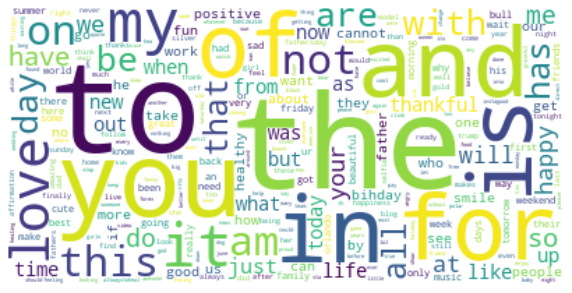

In [53]:
#clean_tweet
words = []
for line in combine_df['clean_tweet']: 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

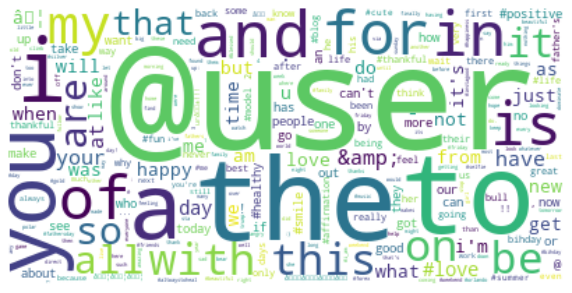

In [54]:
#tweet
words = []
for line in combine_df['tweet']: 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Задание 5.

Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 


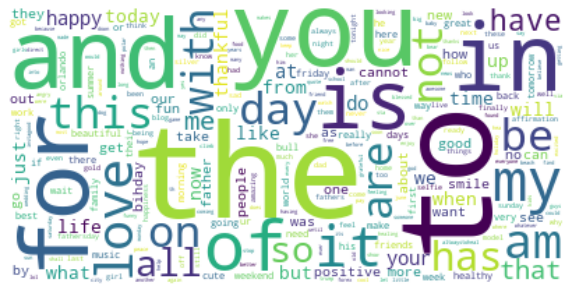

In [60]:
#clean_tweet
words = []
for line in (combine_df[combine_df['label'] == 0]['clean_tweet']): 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

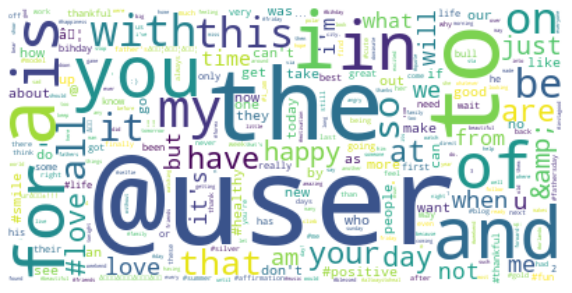

In [61]:
#tweet
words = []
for line in (combine_df[combine_df['label'] == 0]['tweet']): 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Задание 6.

Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

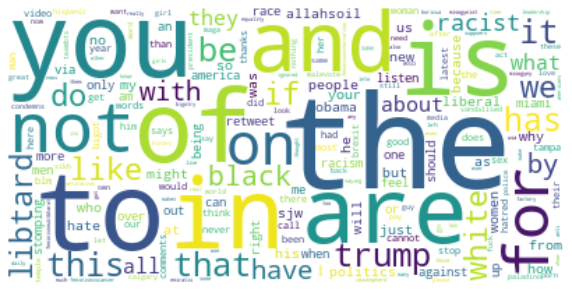

In [62]:
#clean_tweet
words = []
for line in (combine_df[combine_df['label'] == 1]['clean_tweet']): 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

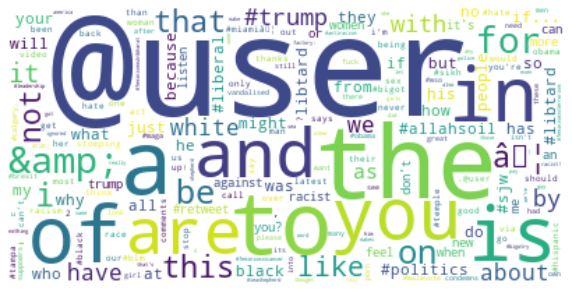

In [63]:
#tweet
words = []
for line in (combine_df[combine_df['label'] == 1]['tweet']): 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Вывод: народ не любит Трампа